In [ ]:
import os, sys
pgm_path = 'PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')

# sys.path.append('DNA_utils/')

In [5]:
# imports

import rbm, RBM_utils

import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from global_variables import *
%matplotlib inline
path = 'seq_data/'
# filename = 'rbd_aligned_sequences_no_gap_ref.fasta'
filename = 'rbd_aligned_sequences.fasta'

Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [3]:
import utilities, Proteins_utils, sequence_logo, plots_utils 
sequences = Proteins_utils.load_FASTA(path + filename) # Load protein sequences.
#shape
print('shape of sequences:', np.shape(sequences))
print('sequences:', sequences)

#remove first 18 columns and last 7 columns
# sequences = [seq[BEGIN:-END] for seq in sequences]
#shape
print('shape of sequences:', np.shape(sequences))
# sequences=one_hot_encode_matrix(sequences)
print('sequences:', sequences)
print('shape of sequences:', np.shape(sequences))

sequences=np.array(sequences)

C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]
shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]
shape of sequences: (2240, 178)


In [7]:
WT_SEQ.shape

(178,)

Max distance: 166


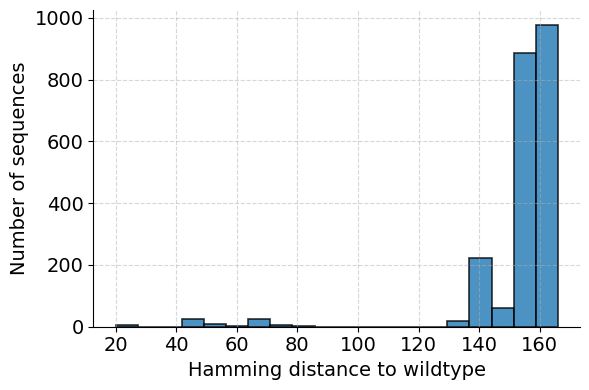

In [12]:
# compute distance of each sequence to the WT

def hamming_distance(s1, s2):
    #check same length
    assert len(s1) == len(s2)
    
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

distances = np.array([hamming_distance(WT_SEQ, seq) for seq in sequences])
#print max
print('Max distance:', np.max(distances))
#histogram of distances

# Create the figure
plt.figure(figsize=(6, 4))  # Slightly larger figure for clarity

# Plotting histogram with enhanced visualization
plt.hist(distances, bins=20, color='#1f77b4', edgecolor='black', linewidth=1.2, alpha=0.8)

# Enhancing the plot for publication
plt.xlabel('Hamming distance to wildtype', fontsize=14)
plt.ylabel('Number of sequences', fontsize=14)

# Adding subtle grid with better style
plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.5)

# Customizing ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Removing top and right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [13]:
#remove sequences with distance > 150
# sequences = sequences[distances <= 160]
print('shape of sequences:', np.shape(sequences))

shape of sequences: (2240, 178)


In [14]:
perm = np.arange(sequences.shape[0])
#fix seed
np.random.seed(2)
np.random.shuffle(perm)

len_validation = sequences.shape[0] // 10
train_sequences=sequences[perm[:-len_validation]]
validation_sequences=sequences[perm[-len_validation:]]
rand_data = np.random.randint(low=0, high=20, size=train_sequences.shape, dtype=np.int16)

print('Train sequences shape:', train_sequences.shape)
print('Validation sequences shape:', validation_sequences.shape)
print('Random data shape:', rand_data.shape)

#unfix seed
np.random.seed(None)


Train sequences shape: (2016, 178)
Validation sequences shape: (224, 178)
Random data shape: (2016, 178)


In [16]:

#first row is WT
train_sequences=np.vstack([WT_SEQ, train_sequences])
print('Train sequences shape:', train_sequences.shape)


Train sequences shape: (2017, 178)


## Train RBM on prepandemic sequences

In [10]:

# sequence_weights = 1.0/Proteins_utils.count_neighbours(train_sequences) # Compute sequence weights.
#uniform weights
sequence_weights = np.ones(train_sequences.shape[0])
#first seq should have higher weight

# RBM = rbm.RBM(
#               visible = 'Potts', # Categorical visible data.
#               hidden = 'dReLU', # double ReLU hidden units.
#               n_v = sequences.shape[-1], # Data dimension (here, number of columns in MSA)
#               n_cv = 21, # Number of categories (here, 20 amino acids + 1 gap)
#               n_h = 100 # Number of hidden units: 100
#               ) # RBM object initialization.

# RBM.fit(train_sequences, weights = sequence_weights, n_iter=50, N_MC=10,verbose=1, vverbose=1, l1b=0.12) # Fit by Persistent Contrastive Divergence for 500 epochs, 10 Monte Carlo steps; L_1^2 sparse regularization penalty = 0.1.
# RBM_utils.saveRBM('test_wt_RBM_Covid.data',RBM)
# print( RBM.likelihood(train_sequences).mean() ) # Evaluate partition function Z by Annealed Importance Sampling, then evaluate  sequences likelihood.

# plots_utils.make_all_weights(RBM,sequences,name = 'all_weights_WW.pdf',pdb_file='2n1o') # For each hidden unit of the trained RBM model, show weight logo, input distribution and  attached for all hidden units and map them onto a PDB structure.


In [17]:
RBM=RBM_utils.loadRBM('test_wt_RBM_Covid.data')


Computing log(Z) with AIS...
Mismatch dimensions (100, 100), [5, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [5, 178, 21], reinitializating I
logZ=1568.1262


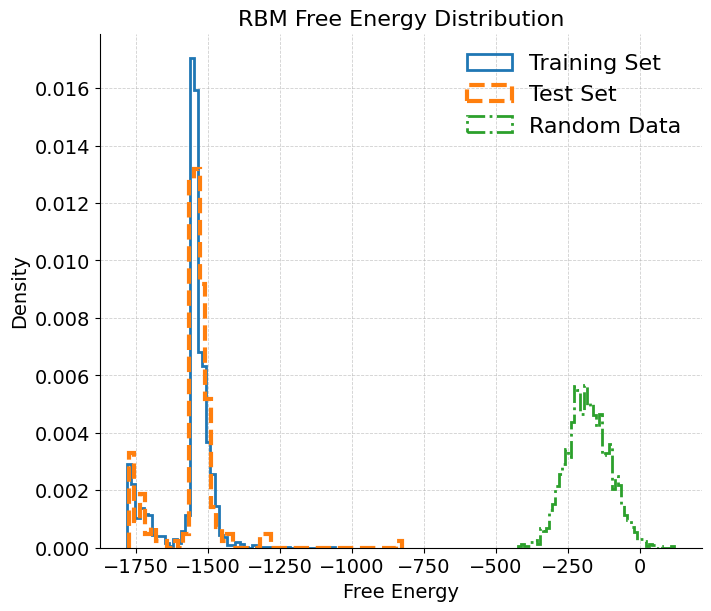

In [12]:
# Create the figure
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

# Plot histogram with enhanced visibility
ax.hist(RBM.free_energy(train_sequences), bins=50, density=True, histtype='step', 
        lw=2, linestyle='-', color='#1f77b4', label="Training Set")

ax.hist(RBM.free_energy(validation_sequences), bins=50, density=True, histtype='step', 
        lw=3, linestyle='--', color='#ff7f0e', label="Test Set")

ax.hist(RBM.free_energy(rand_data), bins=50, density=True, histtype='step', 
        lw=2, linestyle='-.', color='#2ca02c', label="Random Data")

# Enhancing aesthetics
ax.set_xlabel("Free Energy", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("RBM Free Energy Distribution", fontsize=16)

# Adding likelihood annotation inside the plot
mean_likelihood = RBM.likelihood(validation_sequences).mean()

# Customizing legend
ax.legend(fontsize=16, loc='upper right', frameon=False)

# Customizing ticks and grid
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# Removing top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()

# Application to df bloom

# protein Expression

In [18]:
df_bloom=pd.read_csv('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.csv')
df_bloom=df_bloom[df_bloom['site_SARS2']>=349] 
df_bloom=df_bloom[df_bloom['site_SARS2']<=526]
#reset index
df_bloom=df_bloom.reset_index(drop=True)
#sequence column to fasta file
with open('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta', 'w') as f:
    for index, row in df_bloom.iterrows():
        #if * in sequence, remove sequence
        if '*' in row['sequence']:
            continue
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')
# df_bloom

In [19]:
df_bloom.shape

(3327, 13)

In [20]:
bloom_sequences=Proteins_utils.load_FASTA('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta')
print('shape of sequences:', np.shape(bloom_sequences))
bloom_sequences = [seq[BEGIN:-END] for seq in bloom_sequences]
bloom_sequences=np.array(bloom_sequences)
# bloom_sequences=one_hot_encode_matrix(bloom_sequences)
bloom_sequences.shape

shape of sequences: (3327, 201)


(3327, 178)

In [21]:
#onley keep site_SARS2 between 349 and 526

df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [22]:

#for each sequence in df_bloom, compute likelihood
sequences_likelihood = RBM.likelihood(bloom_sequences)
df_bloom['likelihood'] = sequences_likelihood
#replace nan by -300
sequences_likelihood

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


array([35.933716, 26.411255, 35.991333, ..., 34.144165, 33.83728 ,
       22.788818], dtype=float32)

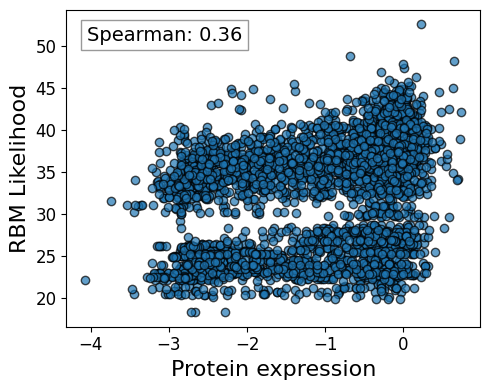

(0.35795432273925204, 3.856864712722513e-101, -1090.8738367130363)

In [24]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

# Data
x = df_bloom['expr_avg']
y = df_bloom['likelihood']

# Metrics
spearman_corr, spearman_pval = stats.spearmanr(x, y)
r2 = r2_score(x, y)

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='#1f77b4', alpha=0.7, edgecolor='black')

plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('RBM Likelihood', fontsize=16)

# Stats box
plt.text(
    0.05, 0.95, f"Spearman: {spearman_corr:.2f}",
    transform=plt.gca().transAxes, fontsize=14, va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey')
)

# Optional: highlight wildtype at (0, 0)
# plt.scatter(0, 0, color='red', marker='D', s=100, label='Wildtype')
# plt.annotate('Wildtype', xy=(0, 0), xytext=(-1, -0.2), fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

spearman_corr, spearman_pval, r2


# Grouping by site

In [26]:
WT_embe=Proteins_utils.load_FASTA('seq_data/rbd_wt.fasta')
WT_embe = [seq[BEGIN:-END] for seq in WT_embe]
WT_embe=np.array(WT_embe)
likelihood_WT = RBM.likelihood(WT_embe)
print('likelihood_WT:', likelihood_WT)

likelihood_WT: [42.7323]


In [27]:
df_bloom['deltaE'] = -likelihood_WT+df_bloom['likelihood']
df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence,likelihood,deltaE
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...,35.933716,-6.798584
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...,26.411255,-16.321045
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...,35.991333,-6.740967
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...,38.287354,-4.444946
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...,26.411011,-16.321289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,32.805786,-9.926514
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,35.472534,-7.259766
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,34.144165,-8.588135
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,33.837280,-8.895020


In [28]:
df_bloom_avg = df_bloom.groupby('site_SARS2').agg(lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.iloc[0]).reset_index()



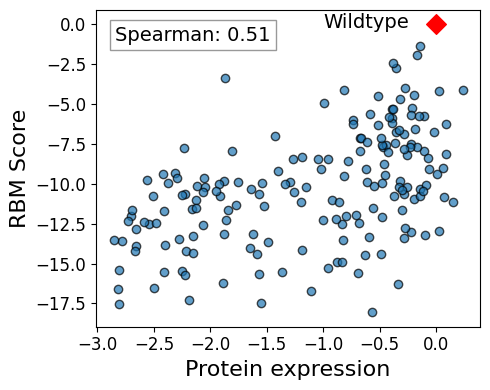

(0.5053839172958808, 6.261294035859421e-13, -117.73202523120155)

In [29]:
import scipy.stats as stats
from sklearn.metrics import r2_score

# Calculate Spearman correlation
spearman_corr, spearman_pval = stats.spearmanr(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Calculate R² score
r2 = r2_score(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Create figure
plt.figure(figsize=(5, 4))  # Slightly larger for readability

# Scatter plot with enhanced visualization
plt.scatter(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'], color='#1f77b4', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('RBM Score', fontsize=16)
# plt.title(r'$\Delta E_{RBM}$ vs Expression Average', fontsize=16)

# Adding Spearman correlation in a small box inside the plot
textstr = f"Spearman: {spearman_corr:.2f}"
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))

# Grid and ticks
# plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Removing top and right spines for a cleaner look
ax = plt.gca()

plt.scatter(0, 0, color='red', marker='D', s=100, label='Wildtype')
#annotate
plt.annotate('Wildtype', xy=(0, 0), xytext=(-1,- 0.2),
             fontsize=14)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Print correlation and R² score
spearman_corr, spearman_pval, r2
